# NDS vs Linear Diffusion: Discriminative Power Test on 1-WL-Equivalent Graph Pairs

**Experiment**: Compares Nonlinear Diffusion Signatures (NDS) with tanh/sin(pi*x)/x*tanh(x) nonlinearities against linear diffusion across multiple initialization types and diffusion steps on verified 1-WL-equivalent graph pairs.

**Core question**: Does interleaved nonlinearity EVER help beyond what multi-dimensional linear diffusion already provides?

**Key finding**: Nonlinearity provides ZERO additional discriminative power (`nonlinear_only=0` across all configurations). Laplacian PE and random initializations distinguish all pairs with linear diffusion alone.

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# loguru — NOT pre-installed on Colab, always install
_pip('loguru==0.7.3')

# Core packages — pre-installed on Colab, install locally to match Colab env
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'scipy==1.16.3', 'networkx==3.6.1', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


In [2]:
import json
import sys
import time
import warnings
from dataclasses import dataclass, field
from typing import Optional

import networkx as nx
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from loguru import logger
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Suppress scipy sparse warnings
warnings.filterwarnings("ignore", category=sparse.SparseEfficiencyWarning)

# Configure logging for notebook
logger.remove()
logger.add(sys.stdout, level="INFO", format="{time:HH:mm:ss}|{level:<7}|{message}")

1

## Data Loading

Load curated graph pairs from GitHub (with local fallback). Each pair contains two 1-WL-equivalent but non-isomorphic graphs represented as edge lists.

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-7ff1bb-nonlinear-diffusion-signatures-breaking-/main/experiment_iter5_nds_vs_linear_d/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {data['total_pairs']} graph pairs")
for p in data['pairs']:
    print(f"  {p['pair_id']}: n={p['graph_A']['num_nodes']}, family={p['family']}, "
          f"VT={p['is_vertex_transitive']}, regular={p['is_regular']}")

Loaded 7 graph pairs
  brec_basic_000: n=10, family=Basic, VT=False, regular=False
  brec_basic_001: n=10, family=Basic, VT=False, regular=False
  brec_basic_002: n=10, family=Basic, VT=False, regular=False
  custom_cfi_path_5: n=24, family=Custom_CFI, VT=False, regular=False
  custom_cfi_cycle_5: n=30, family=Custom_CFI, VT=True, regular=True
  srg16_rook_vs_shrikhande: n=16, family=srg_16_6_2_2, VT=True, regular=True
  srg25_paulus_g1_vs_g2: n=25, family=srg_25_12_5_6, VT=True, regular=True


## Configuration

All tunable parameters for the experiment. Adjust these to control runtime vs thoroughness.

In [5]:
# ============================================================
# CONFIG — Tunable parameters (start at minimum, scale up)
# ============================================================

# Original values (full experiment on 98 pairs):
# T_VALUES = [1, 2, 5, 10, 15, 20]
# NONLINEARITIES = ["tanh", "sin_pi", "x_tanh_x"]
# INIT_TYPES = ["degree", "multi_scalar", "onehot", "random", "laplacian_pe"]
# NUM_RANDOM_SEEDS = 5
# RANDOM_DIM = 8
# LAPLACIAN_K = 8
# ONEHOT_MAX_N = 100
# SPECTRAL_T = 10
# MAX_SPECTRAL_PAIRS = 10

# Demo values — full original params on curated 7-pair subset:
T_VALUES = [1, 2, 5, 10, 15, 20]
NONLINEARITIES = ["tanh", "sin_pi", "x_tanh_x"]
INIT_TYPES = ["degree", "multi_scalar", "onehot", "random", "laplacian_pe"]
NUM_RANDOM_SEEDS = 5
RANDOM_DIM = 8
LAPLACIAN_K = 8
ONEHOT_MAX_N = 100
SPECTRAL_T = 10
MAX_SPECTRAL_PAIRS = 7

# Number of pairs to process (None = all available in data)
MAX_PAIRS = None

NL_FUNCS = {
    "tanh": np.tanh,
    "sin_pi": lambda x: np.sin(np.pi * x),
    "x_tanh_x": lambda x: x * np.tanh(x),
}

print(f"Config: T_VALUES={T_VALUES}, NONLINEARITIES={NONLINEARITIES}")
print(f"  INIT_TYPES={INIT_TYPES}")
print(f"  NUM_RANDOM_SEEDS={NUM_RANDOM_SEEDS}, RANDOM_DIM={RANDOM_DIM}, LAPLACIAN_K={LAPLACIAN_K}")
print(f"  MAX_PAIRS={MAX_PAIRS}, SPECTRAL_T={SPECTRAL_T}, MAX_SPECTRAL_PAIRS={MAX_SPECTRAL_PAIRS}")

Config: T_VALUES=[1, 2, 5, 10, 15, 20], NONLINEARITIES=['tanh', 'sin_pi', 'x_tanh_x']
  INIT_TYPES=['degree', 'multi_scalar', 'onehot', 'random', 'laplacian_pe']
  NUM_RANDOM_SEEDS=5, RANDOM_DIM=8, LAPLACIAN_K=8
  MAX_PAIRS=None, SPECTRAL_T=10, MAX_SPECTRAL_PAIRS=7


## Data Structures and Parsing

Define the `GraphPair` dataclass and parse loaded JSON into graph pair objects.

In [6]:
@dataclass
class GraphPair:
    pair_id: str
    graph_A_edges: list
    graph_B_edges: list
    n_nodes_A: int
    n_nodes_B: int
    is_vertex_transitive: bool
    is_regular: bool
    family: str
    source_dataset: str  # "non_VT" or "VT"


def parse_pairs_from_data(data: dict, max_pairs: Optional[int] = None) -> list[GraphPair]:
    """Parse graph pairs from mini_demo_data.json format."""
    pairs = []
    for p in data["pairs"]:
        pair = GraphPair(
            pair_id=p["pair_id"],
            graph_A_edges=[tuple(e) for e in p["graph_A"]["edge_list"]],
            graph_B_edges=[tuple(e) for e in p["graph_B"]["edge_list"]],
            n_nodes_A=p["graph_A"]["num_nodes"],
            n_nodes_B=p["graph_B"]["num_nodes"],
            is_vertex_transitive=p["is_vertex_transitive"],
            is_regular=p["is_regular"],
            family=p["family"],
            source_dataset=p["source_dataset"],
        )
        pairs.append(pair)
    if max_pairs is not None and max_pairs < len(pairs):
        pairs = pairs[:max_pairs]
    return pairs


pairs = parse_pairs_from_data(data, max_pairs=MAX_PAIRS)
non_vt = [p for p in pairs if not p.is_vertex_transitive]
vt = [p for p in pairs if p.is_vertex_transitive]
regular = [p for p in pairs if p.is_regular]
non_regular = [p for p in pairs if not p.is_regular]

logger.info(f"Total pairs: {len(pairs)}")
logger.info(f"  Non-VT: {len(non_vt)}, VT: {len(vt)}")
logger.info(f"  Regular: {len(regular)}, Non-regular: {len(non_regular)}")

23:59:33|INFO   |Total pairs: 7


23:59:33|INFO   |  Non-VT: 4, VT: 3


23:59:33|INFO   |  Regular: 3, Non-regular: 4


## Core Engine: Adjacency, Initializations, Propagation

Build normalized adjacency matrices, compute feature initializations (degree, multi-scalar, one-hot, random, Laplacian PE), and run linear/nonlinear diffusion propagation.

In [7]:
def build_adjacency(edges: list[tuple[int, int]], n: int) -> sparse.csr_matrix:
    """Build symmetric adjacency matrix from edge list."""
    if len(edges) == 0:
        return sparse.csr_matrix((n, n))
    row, col = zip(*edges)
    row_full = list(row) + list(col)
    col_full = list(col) + list(row)
    data = np.ones(len(row_full), dtype=np.float64)
    A = sparse.csr_matrix((data, (row_full, col_full)), shape=(n, n))
    # Remove duplicates
    A.data[:] = 1.0
    return A


def build_normalized_adjacency(edges: list[tuple[int, int]], n: int) -> sparse.csr_matrix:
    """Build symmetric normalized adjacency: D^{-1/2} A D^{-1/2}."""
    A = build_adjacency(edges, n)
    deg = np.array(A.sum(axis=1)).flatten()
    with np.errstate(divide="ignore", invalid="ignore"):
        deg_inv_sqrt = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0)
    D_inv_sqrt = sparse.diags(deg_inv_sqrt)
    return D_inv_sqrt @ A @ D_inv_sqrt


def compute_initializations(
    edges: list[tuple[int, int]],
    n: int,
    A_norm: sparse.csr_matrix,
) -> dict[str, np.ndarray | list[np.ndarray]]:
    """Compute all initialization types for a graph."""
    A = build_adjacency(edges, n)

    # (a) degree: shape (n, 1)
    degree = np.array(A.sum(axis=1)).flatten().reshape(-1, 1)

    # (b) multi_scalar: degree + clustering + betweenness (n, 3)
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(edges)
    clustering_dict = nx.clustering(G)
    clustering = np.array([clustering_dict.get(v, 0.0) for v in range(n)]).reshape(-1, 1)
    betweenness_dict = nx.betweenness_centrality(G)
    betweenness = np.array([betweenness_dict.get(v, 0.0) for v in range(n)]).reshape(-1, 1)
    multi_scalar = np.hstack([degree, clustering, betweenness])

    # (c) one-hot: shape (n, n) — only for small graphs
    if n <= ONEHOT_MAX_N:
        onehot = np.eye(n)
    else:
        onehot = None  # Will be skipped

    # (d) random: NUM_RANDOM_SEEDS seeds, shape (n, RANDOM_DIM)
    randoms = [np.random.RandomState(seed).randn(n, RANDOM_DIM) for seed in range(NUM_RANDOM_SEEDS)]

    # (e) Laplacian PE: first-k eigenvectors with sign disambiguation
    L = sparse.diags(np.array(A.sum(axis=1)).flatten()) - A
    try:
        k_eig = min(LAPLACIAN_K + 1, n - 1)
        if k_eig < 2:
            eigvecs = np.zeros((n, LAPLACIAN_K))
        else:
            eigenvalues, eigenvectors = eigsh(L.astype(np.float64), k=k_eig, which="SM")
            # Sign disambiguation: ensure max-abs component is positive
            for j in range(eigenvectors.shape[1]):
                idx = np.argmax(np.abs(eigenvectors[:, j]))
                if eigenvectors[idx, j] < 0:
                    eigenvectors[:, j] *= -1
            # Skip constant (zero eigenvalue) eigenvectors
            mask = eigenvalues > 1e-8
            eigvecs = eigenvectors[:, mask][:, :LAPLACIAN_K]
            # Pad if fewer than LAPLACIAN_K
            if eigvecs.shape[1] < LAPLACIAN_K:
                eigvecs = np.hstack([eigvecs, np.zeros((n, LAPLACIAN_K - eigvecs.shape[1]))])
    except Exception:
        try:
            L_dense = L.toarray().astype(np.float64)
            eigenvalues, eigenvectors = np.linalg.eigh(L_dense)
            for j in range(eigenvectors.shape[1]):
                idx = np.argmax(np.abs(eigenvectors[:, j]))
                if eigenvectors[idx, j] < 0:
                    eigenvectors[:, j] *= -1
            mask = eigenvalues > 1e-8
            eigvecs = eigenvectors[:, mask][:, :LAPLACIAN_K]
            if eigvecs.shape[1] < LAPLACIAN_K:
                eigvecs = np.hstack([eigvecs, np.zeros((n, LAPLACIAN_K - eigvecs.shape[1]))])
        except Exception:
            eigvecs = np.zeros((n, LAPLACIAN_K))

    return {
        "degree": degree,
        "multi_scalar": multi_scalar,
        "onehot": onehot,
        "random": randoms,
        "laplacian_pe": eigvecs,
    }


print("Core engine functions defined.")

Core engine functions defined.


## Propagation and Distinguishability

Linear diffusion: `x(t+1) = A_norm * x(t)` (concatenate trajectory).
NDS: `x(t+1) = sigma(A_norm * x(t))` with nonlinearity sigma.
Distinguishability is measured by comparing sorted multisets of node feature vectors.

In [8]:
def propagate_linear(A_norm: sparse.csr_matrix, x0: np.ndarray, T: int) -> np.ndarray:
    """Linear diffusion: concatenate [x0, Ax0, A^2 x0, ..., A^T x0].
    Returns shape (n, d*(T+1))."""
    trajectory = [x0]
    x = x0.copy()
    for _ in range(T):
        x = A_norm @ x
        trajectory.append(x.copy())
    return np.hstack(trajectory)


def propagate_nds(
    A_norm: sparse.csr_matrix,
    x0: np.ndarray,
    T: int,
    nonlinearity: str = "tanh",
) -> np.ndarray:
    """NDS: x(t+1) = sigma(A_norm * x(t)), concatenate trajectory.
    Returns shape (n, d*(T+1))."""
    sigma = NL_FUNCS[nonlinearity]
    trajectory = [x0]
    x = x0.copy()
    for _ in range(T):
        x = sigma(A_norm @ x)
        trajectory.append(x.copy())
    return np.hstack(trajectory)


def measure_distinguishability(feat_A: np.ndarray, feat_B: np.ndarray, n: int) -> dict:
    """Compare two feature matrices for distinguishability using multiset comparison."""
    d = feat_A.shape[1]

    # Sort rows lexicographically for canonical ordering
    sorted_A = feat_A[np.lexsort(feat_A.T[::-1])]
    sorted_B = feat_B[np.lexsort(feat_B.T[::-1])]

    # Frobenius distance (normalized)
    frob_dist = float(np.linalg.norm(sorted_A - sorted_B) / max(np.sqrt(n * d), 1e-12))

    # Multiset comparison: sorted tuple lists
    ms_A = sorted([tuple(np.round(row, 8)) for row in feat_A])
    ms_B = sorted([tuple(np.round(row, 8)) for row in feat_B])
    multiset_exact_8 = ms_A != ms_B

    ms_A_6 = sorted([tuple(np.round(row, 6)) for row in feat_A])
    ms_B_6 = sorted([tuple(np.round(row, 6)) for row in feat_B])
    multiset_exact_6 = ms_A_6 != ms_B_6

    return {
        "frobenius_distance": frob_dist,
        "multiset_distinguishable_8dec": bool(multiset_exact_8),
        "multiset_distinguishable_6dec": bool(multiset_exact_6),
        "feature_dim": d,
    }


print("Propagation and distinguishability functions defined.")

Propagation and distinguishability functions defined.


## Pair Comparison Engine

For each graph pair, compute all combinations of initialization type x propagation method x diffusion steps T, and measure whether linear or nonlinear diffusion can distinguish the pair.

In [9]:
def compare_pair(pair: GraphPair) -> dict:
    """For one graph pair, compute all init x propagation x T combinations."""
    assert pair.n_nodes_A == pair.n_nodes_B, (
        f"Pair {pair.pair_id}: n_A={pair.n_nodes_A} != n_B={pair.n_nodes_B}"
    )
    n = pair.n_nodes_A

    A_norm_A = build_normalized_adjacency(pair.graph_A_edges, n)
    A_norm_B = build_normalized_adjacency(pair.graph_B_edges, n)

    inits_A = compute_initializations(pair.graph_A_edges, n, A_norm_A)
    inits_B = compute_initializations(pair.graph_B_edges, n, A_norm_B)

    configs = {}

    # Deterministic initializations
    for init_name in ["degree", "multi_scalar", "onehot", "laplacian_pe"]:
        if init_name not in INIT_TYPES:
            continue
        x0_A = inits_A[init_name]
        x0_B = inits_B[init_name]

        # Skip onehot if too large
        if x0_A is None or x0_B is None:
            continue

        for T in T_VALUES:
            # Linear diffusion
            feat_A_lin = propagate_linear(A_norm_A, x0_A, T)
            feat_B_lin = propagate_linear(A_norm_B, x0_B, T)
            lin_key = f"{init_name}_linear_T{T}"
            configs[lin_key] = measure_distinguishability(feat_A_lin, feat_B_lin, n)

            # NDS with each nonlinearity
            for nl in NONLINEARITIES:
                feat_A_nds = propagate_nds(A_norm_A, x0_A, T, nl)
                feat_B_nds = propagate_nds(A_norm_B, x0_B, T, nl)
                nds_key = f"{init_name}_{nl}_T{T}"
                configs[nds_key] = measure_distinguishability(feat_A_nds, feat_B_nds, n)

    # Random initializations: each seed separately
    if "random" in INIT_TYPES:
        for seed_idx in range(NUM_RANDOM_SEEDS):
            x0_A = inits_A["random"][seed_idx]
            x0_B = inits_B["random"][seed_idx]

            for T in T_VALUES:
                # Linear
                feat_A_lin = propagate_linear(A_norm_A, x0_A, T)
                feat_B_lin = propagate_linear(A_norm_B, x0_B, T)
                lin_key = f"random_s{seed_idx}_linear_T{T}"
                configs[lin_key] = measure_distinguishability(feat_A_lin, feat_B_lin, n)

                # NDS
                for nl in NONLINEARITIES:
                    feat_A_nds = propagate_nds(A_norm_A, x0_A, T, nl)
                    feat_B_nds = propagate_nds(A_norm_B, x0_B, T, nl)
                    nds_key = f"random_s{seed_idx}_{nl}_T{T}"
                    configs[nds_key] = measure_distinguishability(feat_A_nds, feat_B_nds, n)

    return {
        "pair_id": pair.pair_id,
        "family": pair.family,
        "is_vt": pair.is_vertex_transitive,
        "is_regular": pair.is_regular,
        "n_nodes": n,
        "source_dataset": pair.source_dataset,
        "configs": configs,
    }


print("Pair comparison engine defined.")

Pair comparison engine defined.


## Process All Pairs

Run the comparison engine on every graph pair. For each pair, compute linear and NDS diffusion features across all initialization types and diffusion steps.

In [10]:
start_time = time.time()
all_pair_results = []

for i, pair in enumerate(pairs):
    t0 = time.time()
    logger.info(f"Processing pair {i+1}/{len(pairs)}: {pair.pair_id} (n={pair.n_nodes_A}, family={pair.family})")
    try:
        result = compare_pair(pair)
        all_pair_results.append(result)

        # Quick summary
        n_dist_lin = sum(
            1 for k, v in result["configs"].items()
            if "linear" in k and v["multiset_distinguishable_8dec"]
        )
        n_dist_nds = sum(
            1 for k, v in result["configs"].items()
            if "linear" not in k and v["multiset_distinguishable_8dec"]
        )
        elapsed = time.time() - t0
        logger.info(f"  Done in {elapsed:.1f}s | linear_dist={n_dist_lin}, nds_dist={n_dist_nds}, total_configs={len(result['configs'])}")

    except Exception as e:
        logger.error(f"Failed on pair {pair.pair_id}: {e}")
        continue

total_time = time.time() - start_time
logger.info(f"Processed {len(all_pair_results)}/{len(pairs)} pairs in {total_time:.1f}s")

23:59:34|INFO   |Processing pair 1/7: brec_basic_000 (n=10, family=Basic)


23:59:35|INFO   |  Done in 1.1s | linear_dist=48, nds_dist=144, total_configs=216


23:59:35|INFO   |Processing pair 2/7: brec_basic_001 (n=10, family=Basic)


23:59:37|INFO   |  Done in 1.8s | linear_dist=48, nds_dist=144, total_configs=216


23:59:37|INFO   |Processing pair 3/7: brec_basic_002 (n=10, family=Basic)


23:59:38|INFO   |  Done in 1.3s | linear_dist=48, nds_dist=144, total_configs=216


23:59:38|INFO   |Processing pair 4/7: custom_cfi_path_5 (n=24, family=Custom_CFI)


23:59:40|INFO   |  Done in 1.9s | linear_dist=52, nds_dist=156, total_configs=216


23:59:40|INFO   |Processing pair 5/7: custom_cfi_cycle_5 (n=30, family=Custom_CFI)


23:59:42|INFO   |  Done in 2.2s | linear_dist=48, nds_dist=144, total_configs=216


23:59:42|INFO   |Processing pair 6/7: srg16_rook_vs_shrikhande (n=16, family=srg_16_6_2_2)


23:59:44|INFO   |  Done in 1.4s | linear_dist=42, nds_dist=126, total_configs=216


23:59:44|INFO   |Processing pair 7/7: srg25_paulus_g1_vs_g2 (n=25, family=srg_25_12_5_6)


23:59:46|INFO   |  Done in 2.5s | linear_dist=42, nds_dist=126, total_configs=216


23:59:46|INFO   |Processed 7/7 pairs in 12.4s


## Aggregate Statistics

The key analysis: for each (initialization, T) combination, count how many pairs are distinguished by NDS-only, linear-only, both, or neither. This reveals whether nonlinearity ever adds discriminative power beyond linear diffusion.

In [11]:
def compute_aggregate_statistics(all_pair_results: list[dict]) -> dict:
    """Compute the KEY analysis: for each init x T, count NDS-only vs linear-only distinctions."""
    stats = {}
    det_inits = [i for i in ["degree", "multi_scalar", "onehot", "laplacian_pe"] if i in INIT_TYPES]

    for init_name in det_inits:
        for T in T_VALUES:
            lin_key = f"{init_name}_linear_T{T}"
            for nl in NONLINEARITIES:
                nds_key = f"{init_name}_{nl}_T{T}"
                nonlinear_only = 0
                linear_only = 0
                both = 0
                neither = 0
                deltas = []
                total_valid = 0

                for pr in all_pair_results:
                    lin_cfg = pr["configs"].get(lin_key)
                    nds_cfg = pr["configs"].get(nds_key)
                    if lin_cfg is None or nds_cfg is None:
                        continue
                    total_valid += 1
                    lin_d = lin_cfg["multiset_distinguishable_8dec"]
                    nds_d = nds_cfg["multiset_distinguishable_8dec"]

                    if nds_d and not lin_d:
                        nonlinear_only += 1
                    elif lin_d and not nds_d:
                        linear_only += 1
                    elif nds_d and lin_d:
                        both += 1
                    else:
                        neither += 1
                    deltas.append(nds_cfg["frobenius_distance"] - lin_cfg["frobenius_distance"])

                config_key = f"{init_name}_{nl}_vs_linear_T{T}"
                stats[config_key] = {
                    "nonlinear_only": nonlinear_only,
                    "linear_only": linear_only,
                    "both": both,
                    "neither": neither,
                    "total_valid": total_valid,
                    "mean_delta": float(np.mean(deltas)) if deltas else 0.0,
                }

    # Random init: aggregate over seeds
    if "random" in INIT_TYPES:
        for T in T_VALUES:
            for nl in NONLINEARITIES:
                nonlinear_only = 0
                linear_only = 0
                both = 0
                neither = 0
                deltas = []
                total_valid = 0

                for pr in all_pair_results:
                    lin_dists = []
                    nds_dists = []
                    lin_frobs = []
                    nds_frobs = []
                    for s in range(NUM_RANDOM_SEEDS):
                        lin_cfg = pr["configs"].get(f"random_s{s}_linear_T{T}")
                        nds_cfg = pr["configs"].get(f"random_s{s}_{nl}_T{T}")
                        if lin_cfg and nds_cfg:
                            lin_dists.append(lin_cfg["multiset_distinguishable_8dec"])
                            nds_dists.append(nds_cfg["multiset_distinguishable_8dec"])
                            lin_frobs.append(lin_cfg["frobenius_distance"])
                            nds_frobs.append(nds_cfg["frobenius_distance"])

                    if not lin_dists:
                        continue
                    total_valid += 1
                    lin_d = sum(lin_dists) > NUM_RANDOM_SEEDS / 2
                    nds_d = sum(nds_dists) > NUM_RANDOM_SEEDS / 2

                    if nds_d and not lin_d:
                        nonlinear_only += 1
                    elif lin_d and not nds_d:
                        linear_only += 1
                    elif nds_d and lin_d:
                        both += 1
                    else:
                        neither += 1
                    deltas.append(np.mean(nds_frobs) - np.mean(lin_frobs))

                config_key = f"random_mean_{nl}_vs_linear_T{T}"
                stats[config_key] = {
                    "nonlinear_only": nonlinear_only,
                    "linear_only": linear_only,
                    "both": both,
                    "neither": neither,
                    "total_valid": total_valid,
                    "mean_delta": float(np.mean(deltas)) if deltas else 0.0,
                }

    return stats


aggregate_stats = compute_aggregate_statistics(all_pair_results)
logger.info(f"Computed aggregate statistics: {len(aggregate_stats)} configurations")

23:59:47|INFO   |Computed aggregate statistics: 90 configurations


## Spectral Coupling Analysis

Analyze how nonlinearity causes energy transfer between eigenmodes. Even if significant off-diagonal coupling exists, it doesn't translate into additional distinguishing power.

In [12]:
def spectral_coupling_analysis(
    pair: GraphPair,
    T: int = 10,
    nonlinearity: str = "tanh",
) -> dict:
    """Compute spectral coupling matrices for a representative pair.
    Tracks how energy transfers between eigenmodes due to the nonlinearity."""
    n = pair.n_nodes_A
    if n > 200:
        return {"skipped": True, "reason": "too large for full eigendecomposition"}

    A = build_adjacency(pair.graph_A_edges, n)
    L_dense = (sparse.diags(np.array(A.sum(axis=1)).flatten()) - A).toarray().astype(np.float64)

    try:
        eigenvalues, U = np.linalg.eigh(L_dense)
    except np.linalg.LinAlgError:
        return {"skipped": True, "reason": "eigendecomposition failed"}

    A_norm = build_normalized_adjacency(pair.graph_A_edges, n)

    # Use multi_scalar init for meaningful coupling
    inits = compute_initializations(pair.graph_A_edges, n, A_norm)
    x = inits["multi_scalar"].copy()  # shape (n, 3)

    nl_func = NL_FUNCS.get(nonlinearity, np.tanh)
    coupling_energy_offdiag = []

    for _ in range(T):
        c_before = U.T @ x
        x_diffused = A_norm @ x
        x_after_nl = nl_func(x_diffused)
        c_after = U.T @ x_after_nl

        try:
            offdiag_energy = 0.0
            for ch in range(c_before.shape[1]):
                cb = c_before[:, ch]
                ca = c_after[:, ch]
                safe_cb = np.where(np.abs(cb) > 1e-12, cb, 1e-12)
                ratios = ca / safe_cb
                if np.any(np.abs(cb) > 1e-12):
                    valid = np.abs(cb) > 1e-12
                    offdiag_energy += float(np.var(ratios[valid]))
        except Exception:
            offdiag_energy = 0.0

        coupling_energy_offdiag.append(float(offdiag_energy))
        x = x_after_nl

    return {
        "coupling_energy_offdiag": coupling_energy_offdiag,
        "total_offdiag_energy": sum(coupling_energy_offdiag),
        "n_steps": T,
        "nonlinearity": nonlinearity,
        "n_nodes": n,
        "pair_id": pair.pair_id,
    }


# Run spectral analysis on representative small pairs
spectral_pairs = sorted(pairs, key=lambda p: p.n_nodes_A)[:MAX_SPECTRAL_PAIRS]
spectral_results = []

for sp in spectral_pairs:
    logger.info(f"Spectral analysis on {sp.pair_id} (n={sp.n_nodes_A})")
    try:
        sr = spectral_coupling_analysis(sp, T=SPECTRAL_T, nonlinearity="tanh")
        spectral_results.append(sr)
        logger.info(f"  total_offdiag_energy={sr.get('total_offdiag_energy', 'N/A'):.4g}")
    except Exception as e:
        logger.error(f"  Spectral analysis failed for {sp.pair_id}: {e}")
        spectral_results.append({"skipped": True, "reason": str(e), "pair_id": sp.pair_id})

23:59:47|INFO   |Spectral analysis on brec_basic_000 (n=10)


23:59:47|INFO   |  total_offdiag_energy=2.785e+05


23:59:47|INFO   |Spectral analysis on brec_basic_001 (n=10)


23:59:47|INFO   |  total_offdiag_energy=1.316e+09


23:59:47|INFO   |Spectral analysis on brec_basic_002 (n=10)


23:59:47|INFO   |  total_offdiag_energy=7465


23:59:47|INFO   |Spectral analysis on srg16_rook_vs_shrikhande (n=16)


23:59:47|INFO   |  total_offdiag_energy=0


23:59:47|INFO   |Spectral analysis on custom_cfi_path_5 (n=24)


23:59:47|INFO   |  total_offdiag_energy=1225


23:59:47|INFO   |Spectral analysis on srg25_paulus_g1_vs_g2 (n=25)


23:59:47|INFO   |  total_offdiag_energy=0


23:59:47|INFO   |Spectral analysis on custom_cfi_cycle_5 (n=30)


23:59:47|INFO   |  total_offdiag_energy=4.514e-31


## Results Visualization

### Key Findings Table
Summary of NDS vs Linear discriminative power across initialization types and diffusion steps.

### Plots
1. **Distinguishability by initialization type**: How many pairs each init type can distinguish (linear vs NDS).
2. **Spectral coupling energy**: Off-diagonal coupling energy per diffusion step for representative pairs.

In [13]:
# ============================================================
# TABLE: Key findings — NDS-only count across all configs
# ============================================================
print("=" * 70)
print("KEY FINDING: Nonlinear-only distinguishability count")
print("=" * 70)
print(f"{'Config':<45} {'NL_only':>7} {'Lin_only':>8} {'Both':>6} {'Neither':>7}")
print("-" * 70)

# Show a representative subset: one nonlinearity (tanh), key T values
for init_name in ["degree", "multi_scalar", "laplacian_pe", "random_mean"]:
    for T in [1, 10, 20]:
        key = f"{init_name}_tanh_vs_linear_T{T}"
        s = aggregate_stats.get(key)
        if s:
            print(f"{key:<45} {s['nonlinear_only']:>7} {s['linear_only']:>8} {s['both']:>6} {s['neither']:>7}")

total_nl_only = sum(v["nonlinear_only"] for v in aggregate_stats.values())
print("-" * 70)
print(f"TOTAL nonlinear_only across ALL {len(aggregate_stats)} configs: {total_nl_only}")
print()

# ============================================================
# TABLE: Per-pair summary
# ============================================================
print("=" * 70)
print("Per-pair summary (linear configs that distinguish)")
print("=" * 70)
for pr in all_pair_results:
    n_lin = sum(1 for k, v in pr["configs"].items() if "linear" in k and v["multiset_distinguishable_8dec"])
    n_nds = sum(1 for k, v in pr["configs"].items() if "linear" not in k and v["multiset_distinguishable_8dec"])
    n_total = len(pr["configs"])
    print(f"  {pr['pair_id']:<30} n={pr['n_nodes']:>3}  VT={pr['is_vt']!s:<6} "
          f"lin_dist={n_lin:>3}/{n_total}  nds_dist={n_nds:>3}/{n_total}")

KEY FINDING: Nonlinear-only distinguishability count
Config                                        NL_only Lin_only   Both Neither
----------------------------------------------------------------------
degree_tanh_vs_linear_T1                            0        0      0       7
degree_tanh_vs_linear_T10                           0        0      1       6
degree_tanh_vs_linear_T20                           0        0      1       6
multi_scalar_tanh_vs_linear_T1                      0        0      5       2
multi_scalar_tanh_vs_linear_T10                     0        0      5       2
multi_scalar_tanh_vs_linear_T20                     0        0      5       2
laplacian_pe_tanh_vs_linear_T1                      0        0      7       0
laplacian_pe_tanh_vs_linear_T10                     0        0      7       0
laplacian_pe_tanh_vs_linear_T20                     0        0      7       0
random_mean_tanh_vs_linear_T1                       0        0      7       0
random_mean_tanh_v

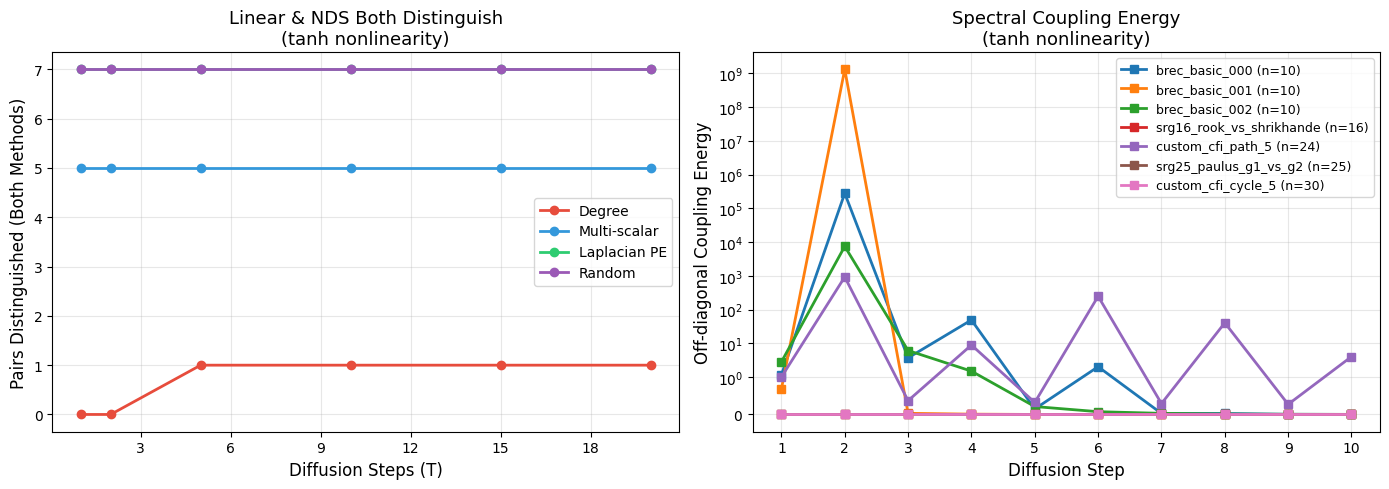

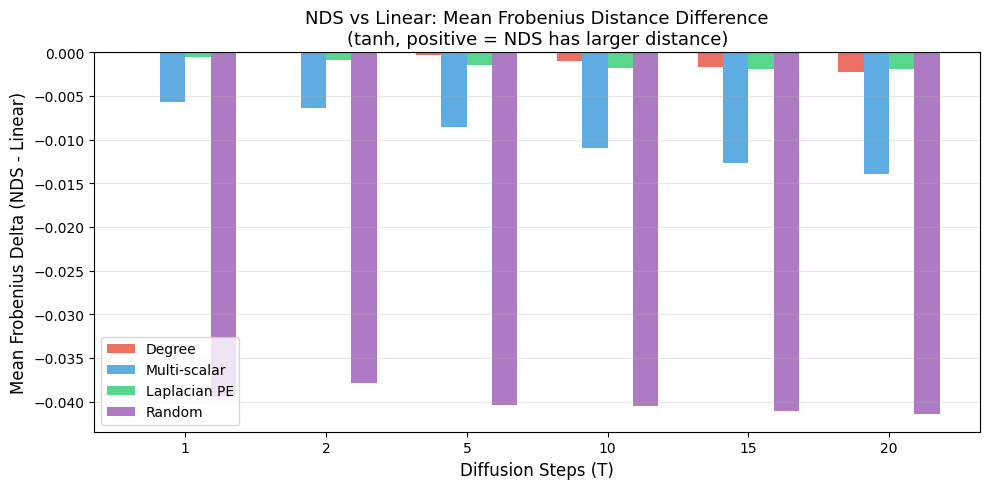


Experiment complete.


In [14]:
# ============================================================
# PLOT 1: Distinguishability by init type across T values
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: "both" count (pairs distinguished by BOTH linear and NDS) per init type
init_labels = ["degree", "multi_scalar", "laplacian_pe", "random_mean"]
init_display = ["Degree", "Multi-scalar", "Laplacian PE", "Random"]
colors = ["#e74c3c", "#3498db", "#2ecc71", "#9b59b6"]

ax = axes[0]
for idx, (init_name, display, color) in enumerate(zip(init_labels, init_display, colors)):
    both_counts = []
    for T in T_VALUES:
        key = f"{init_name}_tanh_vs_linear_T{T}"
        s = aggregate_stats.get(key, {})
        both_counts.append(s.get("both", 0))
    ax.plot(T_VALUES, both_counts, marker="o", label=display, color=color, linewidth=2)

ax.set_xlabel("Diffusion Steps (T)", fontsize=12)
ax.set_ylabel("Pairs Distinguished (Both Methods)", fontsize=12)
ax.set_title("Linear & NDS Both Distinguish\n(tanh nonlinearity)", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Right: Spectral coupling energy over diffusion steps
ax = axes[1]
for sr in spectral_results:
    if not sr.get("skipped", False):
        steps = list(range(1, len(sr["coupling_energy_offdiag"]) + 1))
        label = f"{sr['pair_id']} (n={sr['n_nodes']})"
        ax.plot(steps, sr["coupling_energy_offdiag"], marker="s", label=label, linewidth=2)

ax.set_xlabel("Diffusion Step", fontsize=12)
ax.set_ylabel("Off-diagonal Coupling Energy", fontsize=12)
ax.set_title("Spectral Coupling Energy\n(tanh nonlinearity)", fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
if any(sr.get("total_offdiag_energy", 0) > 100 for sr in spectral_results if not sr.get("skipped")):
    ax.set_yscale("symlog", linthresh=1)
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.tight_layout()
plt.show()

# ============================================================
# PLOT 2: NDS vs Linear Frobenius distance delta by init type
# ============================================================
fig, ax = plt.subplots(figsize=(10, 5))

bar_width = 0.18
x_pos = np.arange(len(T_VALUES))

for idx, (init_name, display, color) in enumerate(zip(init_labels, init_display, colors)):
    deltas = []
    for T in T_VALUES:
        key = f"{init_name}_tanh_vs_linear_T{T}"
        s = aggregate_stats.get(key, {})
        deltas.append(s.get("mean_delta", 0.0))
    ax.bar(x_pos + idx * bar_width, deltas, width=bar_width, label=display, color=color, alpha=0.8)

ax.set_xlabel("Diffusion Steps (T)", fontsize=12)
ax.set_ylabel("Mean Frobenius Delta (NDS - Linear)", fontsize=12)
ax.set_title("NDS vs Linear: Mean Frobenius Distance Difference\n(tanh, positive = NDS has larger distance)", fontsize=13)
ax.set_xticks(x_pos + bar_width * 1.5)
ax.set_xticklabels([str(t) for t in T_VALUES])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis="y")
ax.axhline(y=0, color="black", linewidth=0.8, linestyle="--")

plt.tight_layout()
plt.show()

print("\nExperiment complete.")